In [885]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
import decode
import numpy as np
import importlib
importlib.reload(decode)

<module 'decode' from '/home/bagel/lasercutter/decode.py'>

In [886]:
filename = "box.rd"
with open(filename, "rb") as f:
    data = decode.unscramble(f.read())
cmds = decode.parse_msgs(decode.split_msg(data))

In [888]:
def header(width, height, layers):
    unpacked_msgs = [
        decode.UploadFollows.from_values(),
        decode.F0.from_values(),
        decode.Start2.from_values(),
        decode.LightRed.from_values(),
        decode.Feedrate.from_values(x=0, y=0),
        decode.E738.from_values(),
        decode.Laser1TopLeft.from_values(x=0, y=0),
        decode.Laser1BottomRight.from_values(x=width, y=height),
        decode.Laser2TopLeft.from_values(x=0, y=0),
        decode.Laser2BottomRight.from_values(x=width, y=height),
        decode.E704.from_values(a=1, b=1, x=0, y=0),
        decode.E705.from_values(),
    ]

    for layer in layers:
        unpacked_msgs += layer.to_msg()

    unpacked_msgs += [  
        decode.LayerCount.from_values(layer_count=len(layers)-1),
        decode.PenYOffset.from_values  (device=0, y=0),
        decode.PenYOffset.from_values  (device=1, y=0),
        decode.LaserYOffset.from_values(device=0, y=0),
        decode.LaserYOffset.from_values(device=1, y=0),
        decode.Offset.from_values(x=0, y=0),
        decode.Start0.from_values(),
        decode.Start1.from_values(),
        decode.F200.from_values(),
        decode.Offset2.from_values(x=0, y=0),
        decode.BottomRight.from_values(x=width, y=height),
        decode.F205.from_values(a=1, b=1, x=width, y=height),
        decode.F206.from_values(x=0, y=0),
        decode.F207.from_values(),
        decode.F208.from_values(x=width, y=height),
        decode.E70A.from_values(a=0),
        decode.EA00.from_values(),
        decode.E760.from_values(),
        decode.E300.from_values(),
        decode.E70B.from_values(),
        decode.E713.from_values(a=0, b=0),
        decode.E717.from_values(a=width, b=height),
        decode.E723.from_values(a=0, b=0),
        decode.E724.from_values(),
        decode.E737.from_values(a=width, b=height),
        decode.E708.from_values(unknown_a=1, unknown_b=1, x=width, y=height)
    ]
    return unpacked_msgs

In [914]:
scale_power(100)

14754

In [915]:
def scale_power(x):
    # limit all use cases to 90 % 
    return int(x * 0.90 / 0.0061)

layers = []
for x in range(5):
    for y in range(5):
        layers.append(decode.LayerData(
            color=(0, (x+1)/5.0, (y+1) / 5.0),
            layer=x * 5 + y,
            min_power=scale_power((x + 1) * 20),
            max_power=scale_power((x + 1) * 20),
            speed= (10 * (y + 1)) * 1000,
            x_min=0, y_min=0,
            x_max=0, y_max=0))


unpacked_msgs = header(50000, 50000, layers)


for x in range(5):
    for y in range(5):
        unpacked_msgs += layers[x * 5 + y].change_header()
        
        unpacked_msgs += [
            decode.MoveAbs.from_values(x=int(0 + x * 10000), y=int(0 + y * 10000)),
            decode.CutAbs.from_values(x=int(6000 + x * 10000), y=int(0 + y * 10000)),
            decode.CutAbs.from_values(x=int(6000 + x * 10000), y=int(6000 + y * 10000)),
            decode.CutAbs.from_values(x=int(0 + x * 10000), y=int(6000 + y * 10000)),
            decode.CutAbs.from_values(x=int(0 + x * 10000), y=int(0 + y * 10000))]

unpacked_msgs += [
    decode.E4.from_values(),
    decode.Finish.from_values(),
    decode.E700.from_values(),
    decode.DA01.from_values(a=800, x=80, y=80),
    decode.EOF.from_values(),
]

In [916]:
repacked = []
    
for i in unpacked_msgs:
    if isinstance(i, decode.CmdMsg):
        repacked += i.pack()
        continue
    repacked += i

out_filename = "repacked.rd"
with open(out_filename, "wb") as f:
    f.write(bytearray(decode.scramble(repacked)))

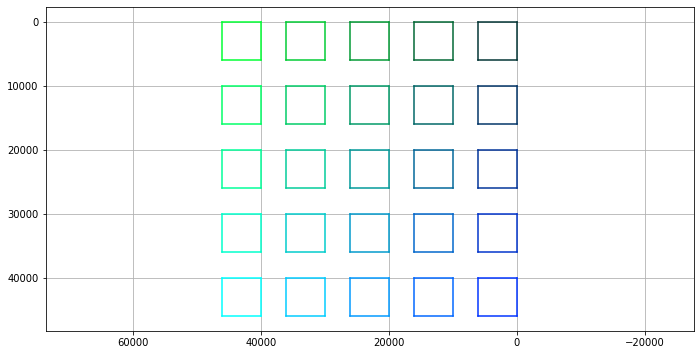

In [909]:
# Output file inspection

with open(out_filename, "rb") as f:
    data = decode.unscramble(f.read())
cmds = decode.parse_msgs(decode.split_msg(data))
laser_sim = decode.LaserSimulator()

for i in cmds:
    if isinstance(i, decode.CmdMsg):
        i.update(laser_sim)
laser_sim.show()
